<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_8_neural_networks_part2/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [3]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** чем больше батч - тем медленее обучение (их дольше считать)

Посмотрим на какую-нибудь картинку:

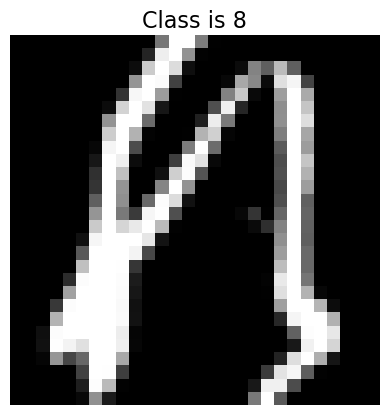

In [4]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

Я починил жабку!

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿\
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿\
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿\
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹\
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧\
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰\
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿\
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿\
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿\
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿\
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿\
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿\
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿\
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





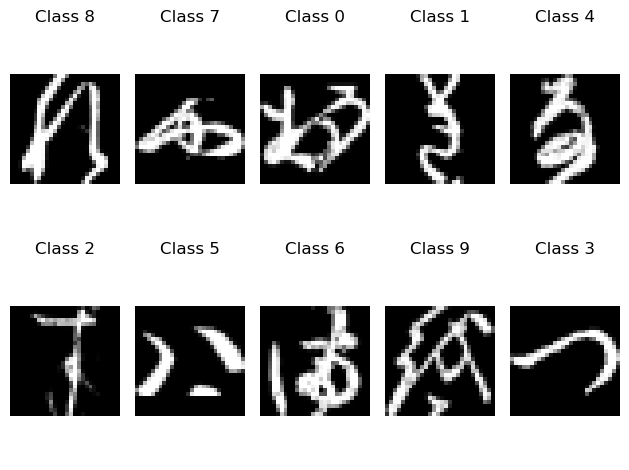

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=5)
classes = []
row = 0
col = 0
plt.setp(axes, xticks=[], yticks=[])

for image, img_class in trainset:
    if img_class not in classes:
        classes.append(img_class)
        fig.add_subplot(2, 5, len(classes))
        plt.imshow(image.view(28, 28).numpy(), cmap="gray")
        axes[col,row].set_axis_off()
        axes[col,row].set_title(f"Class {img_class}")
        plt.axis('off')
        row += 1
    if len(classes) == 10:
        break
    if row == axes.shape[1]:
        row = 0
        col += 1
        
plt.tight_layout()

In [6]:
trainset[0][0].view(-1, 28*28).shape

torch.Size([1, 784])

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

Для следующих заданий я добавил опцию выбора функции активации прямо внутри класса

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

activation_functions = {'ReLU':nn.ReLU, 'Sigmoid':nn.Hardsigmoid, 'GeLU':nn.GELU, 'Tanh':nn.Tanh}

class FCNet(nn.Module):
    def __init__(self, activation_function='ReLU'):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.activation = activation_functions[activation_function]()
        
    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        
        return x

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

784 фичи на входе (28 * 28 * 1). У каждой фичи 256 весов (для каждого нейрона 1 в слое) и у каждого нейрона в первом слое bias.

In [12]:
first_layer_parameters = 784 * 256 + 256
first_layer_parameters

200960

256 фичей на вход второго слоя. 256 * 128 (число нейронов 2 слоя) весов + 128 biases.

In [13]:
second_layers_parameters = 256 * 128 + 128
second_layers_parameters

32896

Ну и наконец, 128 фичей на вход третьего слоя * 10 весов + 10 biases

In [14]:
third_layes_parameters = 128 * 10 + 10
third_layes_parameters

1290

In [15]:
print(f'Общее число параметров модели: {third_layes_parameters + second_layers_parameters + first_layer_parameters}')

Общее число параметров модели: 235146


Думаю можно обобщить это формулой типа \
H1 * (N_features+1) + H2 * (H1+1) + ... + N_classes * (H_out+1), \
Где: \
N_features - число признаков на входе \
H1,...,H_out -  линейные слои сетки\
N_classes - число предсказываемых классов на выходе

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [16]:

def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy
     

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [23]:
# Создадим объект модели
fc_net = FCNet(activation_function='GeLU')
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

Сделаем функцию, которая сама собирает сетку, тренирует ее и выдаёт accuracy. Для следующих заданий добавим в качества опции выбор оптимайзера

In [36]:
optimizers = {'Adam':torch.optim.Adam, 'SGD':torch.optim.SGD,
              'RMSprop':torch.optim.RMSprop, 'Adagrad':torch.optim.Adagrad}

def train_eval_network(n_epochs=10, batch_size = 256, lr=0.001, 
                       activation_function='ReLU', optimizer='Adam', silent=False):
    fc_net = FCNet(activation_function=activation_function)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optimizers[optimizer](fc_net.parameters(), lr=3e-4)

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    loss_history = []
    
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: # Получаем батч тренировочных картинок
            optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
            outputs = fc_net(images) # делаем предсказания
            loss = loss_function(outputs, labels) # считаем лосс
            loss.backward() # считаем градиенты
            optimizer.step() # делаем шаг градиентного спуска

            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))
        
        if not silent:
            print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
    
    return get_accuracy(fc_net, testloader)

In [28]:
train_eval_network()

Epoch=1 loss=0.9069
Epoch=2 loss=0.4468
Epoch=3 loss=0.3523
Epoch=4 loss=0.2960
Epoch=5 loss=0.2532
Epoch=6 loss=0.2203
Epoch=7 loss=0.1924
Epoch=8 loss=0.1691
Epoch=9 loss=0.1494
Epoch=10 loss=0.1320


0.8784

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [30]:
images = []
for i in range(len(trainset)):
    images.append(trainset[i][0].numpy())

In [31]:
images = np.array(images)
mean = np.mean(images)
std = np.std(images)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

In [32]:
print(f'Точность после нормализации изображений составила: {train_eval_network()}')

Epoch=1 loss=0.6914
Epoch=2 loss=0.3092
Epoch=3 loss=0.2284
Epoch=4 loss=0.1763
Epoch=5 loss=0.1409
Epoch=6 loss=0.1145
Epoch=7 loss=0.0931
Epoch=8 loss=0.0768
Epoch=9 loss=0.0632
Epoch=10 loss=0.0497
Точность после нормализации изображений составила: 0.8958


Как изменилась `accuracy` после нормализации?

Увеличилась!

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [37]:
activation_functions = {'ReLU':nn.ReLU, 'Sigmoid':nn.Hardsigmoid, 'GeLU':nn.GELU, 'Tanh':nn.Tanh}
acc_activation = {}
for activation_function in activation_functions.keys():
    print(f'evaluating model with {activation_function}...')
    accuracy = train_eval_network(activation_function=activation_function)
    acc_activation.update({activation_function: accuracy}) 
    print(f'Точность классификации с применением функции активации {activation_function} составила {accuracy}')
best_function = max(acc_activation, key=acc_activation.get)
print(f'Лучшей функцией оказалась {best_function}, её точность:{acc_activation[best_function]}')

evaluating model with ReLU...
Epoch=1 loss=0.6943
Epoch=2 loss=0.3029
Epoch=3 loss=0.2219
Epoch=4 loss=0.1736
Epoch=5 loss=0.1388
Epoch=6 loss=0.1136
Epoch=7 loss=0.0931
Epoch=8 loss=0.0765
Epoch=9 loss=0.0629
Epoch=10 loss=0.0506
Точность классификации с применением функции активации ReLU составила 0.8961
evaluating model with Sigmoid...
Epoch=1 loss=1.6599
Epoch=2 loss=0.8108
Epoch=3 loss=0.5768
Epoch=4 loss=0.4690
Epoch=5 loss=0.3976
Epoch=6 loss=0.3437
Epoch=7 loss=0.3015
Epoch=8 loss=0.2675
Epoch=9 loss=0.2386
Epoch=10 loss=0.2135
Точность классификации с применением функции активации Sigmoid составила 0.8434
evaluating model with GeLU...
Epoch=1 loss=0.6559
Epoch=2 loss=0.2829
Epoch=3 loss=0.2053
Epoch=4 loss=0.1577
Epoch=5 loss=0.1238
Epoch=6 loss=0.0982
Epoch=7 loss=0.0789
Epoch=8 loss=0.0628
Epoch=9 loss=0.0498
Epoch=10 loss=0.0395
Точность классификации с применением функции активации GeLU составила 0.8987
evaluating model with Tanh...
Epoch=1 loss=0.7746
Epoch=2 loss=0.3872


С использованием какой функции активации удалось досчить наибольшей `accuracy`?

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [38]:
optimizers = {'Adam':torch.optim.Adam, 'SGD':torch.optim.SGD, 
              'RMSprop':torch.optim.RMSprop, 'Adagrad':torch.optim.Adagrad}

In [39]:
acc_optimizers = {}
best_activation = max(acc_activation, key=acc_activation.get)
for optimizer in optimizers.keys():
    print(f'evaluating model with {optimizer}...')
    accuracy = train_eval_network(activation_function=best_activation, optimizer=optimizer)
    acc_optimizers.update({optimizer: accuracy}) 
    print(f'Точность классификации с применением оптимизатора {optimizer} составила {accuracy}')
best_optimizer = max(acc_optimizers, key=acc_optimizers.get)
print(f'Лучшей функцией оказалась {best_optimizer}, её точность:{acc_optimizers[best_optimizer]}')

evaluating model with Adam...
Epoch=1 loss=0.7707
Epoch=2 loss=0.3784
Epoch=3 loss=0.2564
Epoch=4 loss=0.1868
Epoch=5 loss=0.1401
Epoch=6 loss=0.1057
Epoch=7 loss=0.0800
Epoch=8 loss=0.0607
Epoch=9 loss=0.0445
Epoch=10 loss=0.0334
Точность классификации с применением оптимизатора Adam составила 0.9
evaluating model with SGD...
Epoch=1 loss=2.2611
Epoch=2 loss=2.2093
Epoch=3 loss=2.1595
Epoch=4 loss=2.1114
Epoch=5 loss=2.0648
Epoch=6 loss=2.0194
Epoch=7 loss=1.9749
Epoch=8 loss=1.9315
Epoch=9 loss=1.8891
Epoch=10 loss=1.8477
Точность классификации с применением оптимизатора SGD составила 0.4689
evaluating model with RMSprop...
Epoch=1 loss=0.5756
Epoch=2 loss=0.3173
Epoch=3 loss=0.2193
Epoch=4 loss=0.1607
Epoch=5 loss=0.1201
Epoch=6 loss=0.0900
Epoch=7 loss=0.0683
Epoch=8 loss=0.0510
Epoch=9 loss=0.0390
Epoch=10 loss=0.0280
Точность классификации с применением оптимизатора RMSprop составила 0.8861
evaluating model with Adagrad...
Epoch=1 loss=1.4004
Epoch=2 loss=1.0251
Epoch=3 loss=0.89

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [42]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x
        x = (x + x.abs())/2
        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [43]:
activation_functions.update({'CustomReLU':CustomReLU})

In [44]:
train_eval_network(activation_function='CustomReLU')

Epoch=1 loss=0.6936
Epoch=2 loss=0.3041
Epoch=3 loss=0.2235
Epoch=4 loss=0.1744
Epoch=5 loss=0.1376
Epoch=6 loss=0.1126
Epoch=7 loss=0.0912
Epoch=8 loss=0.0734
Epoch=9 loss=0.0620
Epoch=10 loss=0.0495


0.8966

Значения accuracy и loss не изменились по сравнению с обычной ReLU 

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

картиночки сгенерированы при помощи этого сайта: https://fusionbrain.ai/diffusion

### <center> Земфира целуется с Ренатой Литвиновой (стиль иконописи)

![alt](shipping.png "")

### <center> Горшок из группы Король и Шут воскрес

![alt](gorshok.png "")

### <center> Агент Купер из сериала ТвинПикс в обтягивающих стрингах (стиль советский мультфильм)

![alt](too_hot_for_me.png "")